# Using Google's inception V3 model in Ipython.


Inception V3 Model reached an top-5 error rate of 3.46%. I am rewritting the tutorial:
https://www.tensorflow.org/versions/r0.11/tutorials/image_recognition/index.html

The code is from the file classify_image.py

In [2]:
import os.path
import re
import sys
import tarfile
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt 
import numpy as np
from six.moves import urllib
import tensorflow as tf
print "Package Loaded"

Package Loaded


In [5]:
# Define the location of where you want the model and the number of predictions to output
model = {
    'model_dir':'/tmp/imagenet',
    'num_top_predictions': 5
}

# tensorflow model location
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

In [6]:
# Download the model
def maybe_download_and_extract():
    """Download and extract model tar file."""
    dest_directory = model['model_dir']
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
              filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

>> Downloading inception-2015-12-05.tgz 100.0%()
('Succesfully downloaded', 'inception-2015-12-05.tgz', 88931400, 'bytes.')


In [7]:
#Creates graph from saved graph_def.pb.
def create_graph():    
    with tf.gfile.FastGFile(os.path.join(
    model['model_dir'], 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [8]:
# Converts integer node ID's to human readable labels.
class NodeLookup(object):

    def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(
              model['model_dir'], 'imagenet_2012_challenge_label_map_proto.pbtxt')
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(
              model['model_dir'], 'imagenet_synset_to_human_label_map.txt')
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.

        Args:
          label_lookup_path: string UID to integer node ID.
          uid_lookup_path: string UID to human-readable string.

        Returns:
          dict from integer node ID to human-readable string.
        """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist %s', uid_lookup_path)
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist %s', label_lookup_path)

        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: %s', val)
            name = uid_to_human[val]
            node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

In [9]:
def run_inference_on_image(image):
    
    if not tf.gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
    image_data = tf.gfile.FastGFile(image, 'rb').read()

    # Creates graph from saved GraphDef.
    create_graph()

    with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
        softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
        predictions = sess.run(softmax_tensor,
                               {'DecodeJpeg/contents:0': image_data})
        predictions = np.squeeze(predictions)

        # Creates node ID --> English string lookup.
        node_lookup = NodeLookup()

        top_k = predictions.argsort()[-model['num_top_predictions']:][::-1]
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)' % (human_string, score))

In [10]:
# random test image 
image_path = "wolf.jpg"

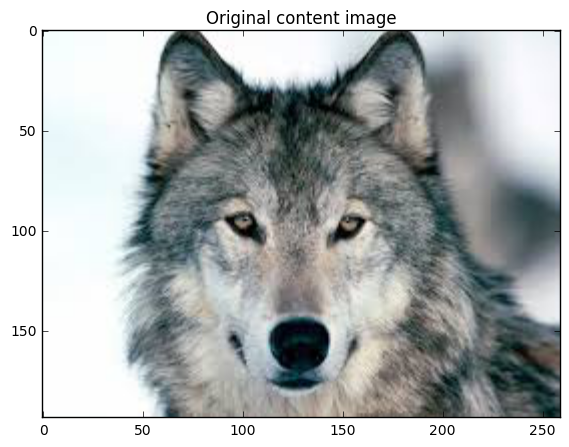

In [15]:
raw_content = scipy.misc.imread(image_path)
plt.figure(0, figsize=(8, 5))
plt.imshow(raw_content)
plt.title("Original content image")
plt.show()

In [14]:
run_inference_on_image(image_path)

timber wolf, grey wolf, gray wolf, Canis lupus (score = 0.48626)
white wolf, Arctic wolf, Canis lupus tundrarum (score = 0.17731)
red wolf, maned wolf, Canis rufus, Canis niger (score = 0.08512)
coyote, prairie wolf, brush wolf, Canis latrans (score = 0.03133)
dingo, warrigal, warragal, Canis dingo (score = 0.03036)
